# Lab 4

In [1]:
%matplotlib inline

import itertools
from IPython.display import display 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import statsmodels.formula.api as smf
import sys

sys.path.append('../src/')
import utils

mpl.rcParams['legend.fontsize'] = 'small'

In [2]:
data = utils.readmat_struct('glaciers.mat', 'glaciers', indexnm='WGMS ID')
data = data.rename(columns={nm : nm.replace(' ', '_') for nm in data.columns})

# Remove any rows with negative mass balance
data = data.iloc[np.where(data['g'] >= 0)[0]]

# Re-order columns to be consistent with Matlab script
cols = ['g', 'lat', 'lon', 'max_elevation', 'median_elevation', 'precipitation', 
        'winter_precipitation', 'continentality', 'cloud_cover', 'summer_temperature', ]
data = data[cols]

data.head()

,g,lat,lon,max_elevation,median_elevation,precipitation,winter_precipitation,continentality,cloud_cover,summer_temperature
2000,8.102728,-54.78,-68.40,1172.5,1071.00,483.990,36.273333,8.395,63.393750,7.626667
1305,1.860170,47.04,12.97,2950.0,2660.00,1637.810,91.578333,18.830,61.731667,11.663333
535,9.194071,47.48,13.62,2910.0,2560.00,1521.845,83.785000,20.045,61.529583,14.881667
491,4.162200,46.80,10.77,3715.5,3039.75,1550.760,93.790000,18.725,62.957083,11.683333
480,4.411077,46.85,10.15,3140.0,2795.00,1726.480,110.065000,17.855,64.265417,10.561667


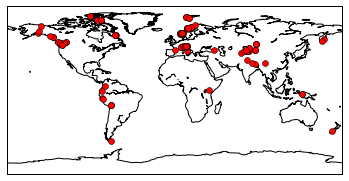

In [3]:
m = Basemap()
m.drawcoastlines()
m.plot(data['lon'], data['lat'], 'ro')

In [54]:
# Standardize variables
data_st = utils.standardize(data)
data_st.head()

,g,lat,lon,max_elevation,median_elevation,precipitation,winter_precipitation,continentality,cloud_cover,summer_temperature
2000,0.729295,-4.510634,-0.917411,-1.305564,-1.127617,-1.008986,-0.826765,-1.567918,-0.073330,-0.610002
1305,-1.252792,-0.009790,0.221562,0.000761,0.077903,0.634920,0.080425,-0.270948,-0.285946,0.303656
535,1.075809,0.009659,0.230660,-0.028636,0.002036,0.469699,-0.047412,-0.119936,-0.311797,1.032093
491,-0.521870,-0.020399,0.190768,0.563344,0.366006,0.510896,0.116703,-0.283999,-0.129189,0.308183
480,-0.442849,-0.018189,0.182089,0.140396,0.180323,0.761253,0.383669,-0.392131,0.038174,0.054305


In [5]:
kmax = 3
pca = utils.princomp(data_st, kmax=kmax)
eigval, eigvec, PCs = pca['eigval'], pca['eigvec'], pca['scores']

array([ 0.37240118,  0.29924396,  0.11863338,  0.06573434,  0.05623408,
        0.03545423,  0.030943  ,  0.01468726,  0.00506168,  0.00160689])

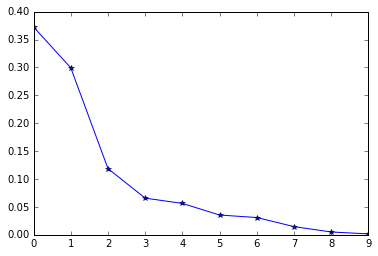

In [7]:
plt.plot(pca['varfrac_all'], '*-')
display(pca['varfrac_all'])

In [8]:
def plot_eigvec(eigvec, imode, varfrac=None, x=None):
    vec = eigvec[imode]
    if x is None:
        x = range(1, len(vec) + 1)
    plt.plot(x, vec)
    plt.xlabel('variables')
    title = 'e%d' % (imode + 1)
    if varfrac is not None:
        title = title + ' var=%.2f' % varfrac[imode]
    plt.title(title)

    
def plot_pc(PCs, imode, x=None):
    pc = PCs[:, imode]
    if x is None:
        x = range(1, len(pc) + 1)
    plt.plot(x, pc)
    plt.xlabel('index of glaciers')
    plt.title('PC%d' % (imode + 1))
    

def plot_modes(eigvec, PCs, kmax, eigvec_func, pc_func, eigvec_kw={}, pc_kw={},
               eigvec_as_rows=True, axes=None, subplots_kw={}):
    if eigvec_as_rows:
        nrows, ncols, order = 2, kmax, 'F'
    else:
        nrows, ncols, order = kmax, 2, 'C'
    if axes is None:
        fig, axes = plt.subplots(nrows, ncols, **subplots_kw)
    axes = axes.ravel(order=order)
    iplot = 0
    for imode in range(kmax):
        plt.sca(axes[iplot])
        eigvec_func(eigvec, imode, **eigvec_kw)
        iplot += 1
        plt.sca(axes[iplot])
        pc_func(PCs, imode, **pc_kw)
        iplot += 1

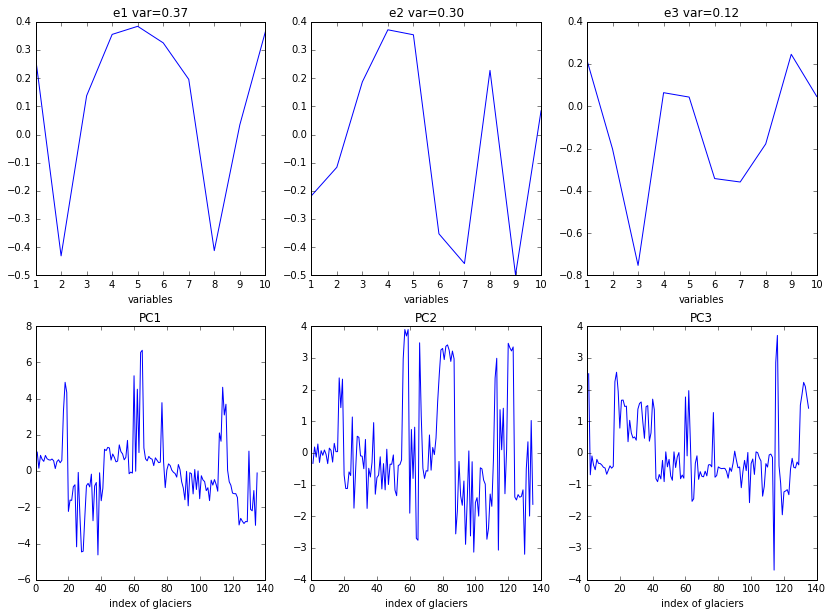

In [9]:
plot_modes(eigvec, PCs, kmax=3, eigvec_func=plot_eigvec, pc_func=plot_pc,
           eigvec_kw={'varfrac' : pca['varfrac']}, eigvec_as_rows=True,
           subplots_kw={'figsize' : (14, 10)})

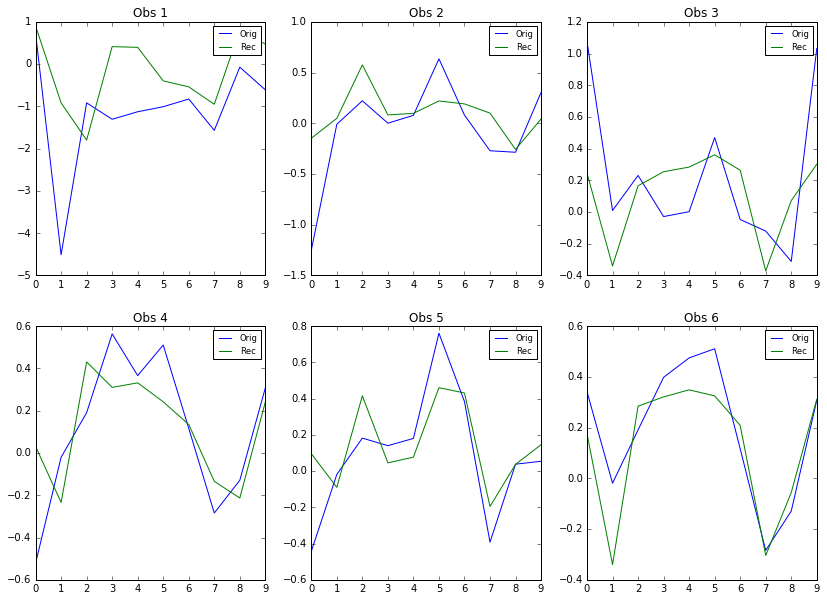

In [21]:
# Reconstructed data
y_rec = pca['y_rec']

plt.figure(figsize=(14, 10))
for iobs in range(6):
    plt.subplot(2, 3, iobs + 1)
    plt.plot(data_st.iloc[iobs].values, label='Orig')
    plt.plot(y_rec[iobs], label='Rec')
    plt.legend()
    plt.title('Obs %d' % (iobs + 1))

In [55]:
# how do the most 'generic' glaciers look like according to these fewer modes?
# finding the 'generic' glacier, i.e. the one with minimum RMSE between reconstructed and original data
err = data_st - y_rec
rmse = (err.apply(np.square).sum(axis=1)/100).apply(np.sqrt)
data_st['rmse'] = rmse
data_st.head()

,g,lat,lon,max_elevation,median_elevation,precipitation,winter_precipitation,continentality,cloud_cover,summer_temperature,rmse
2000,0.729295,-4.510634,-0.917411,-1.305564,-1.127617,-1.008986,-0.826765,-1.567918,-0.073330,-0.610002,0.466689
1305,-1.252792,-0.009790,0.221562,0.000761,0.077903,0.634920,0.080425,-0.270948,-0.285946,0.303656,0.132198
535,1.075809,0.009659,0.230660,-0.028636,0.002036,0.469699,-0.047412,-0.119936,-0.311797,1.032093,0.135240
491,-0.521870,-0.020399,0.190768,0.563344,0.366006,0.510896,0.116703,-0.283999,-0.129189,0.308183,0.076219
480,-0.442849,-0.018189,0.182089,0.140396,0.180323,0.761253,0.383669,-0.392131,0.038174,0.054305,0.071405


In [71]:
data_sorted = data_st.sort_values('rmse')
data_sorted.head()

,g,lat,lon,max_elevation,median_elevation,precipitation,winter_precipitation,continentality,cloud_cover,summer_temperature,rmse
316,-0.024395,0.859701,0.242138,-1.211861,-1.143549,0.796124,1.454700,0.089494,1.036173,-0.282941,0.038989
507,0.341358,-0.019073,0.191048,0.398354,0.474938,0.510896,0.116703,-0.283999,-0.129189,0.308183,0.045793
510,-0.186006,-0.021283,0.194127,0.346175,0.267569,0.510896,0.116703,-0.283999,-0.129189,0.308183,0.047104
675,-0.212127,-0.013327,0.197206,0.034127,0.169095,0.510896,0.116703,-0.283999,-0.129189,0.308183,0.047691
805,-0.704786,-0.240093,1.134196,1.360368,1.285698,-1.254421,-1.251257,1.024779,-1.555565,0.376084,0.048808


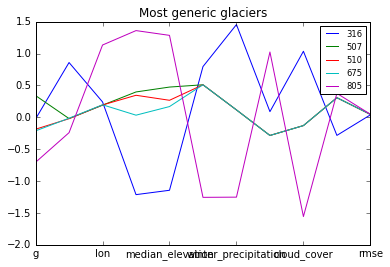

In [81]:
generics = data_sorted.iloc[:5]
for ind, glacier in generics.iterrows():
    glacier.plot(label=ind)
plt.legend()
plt.title('Most generic glaciers')

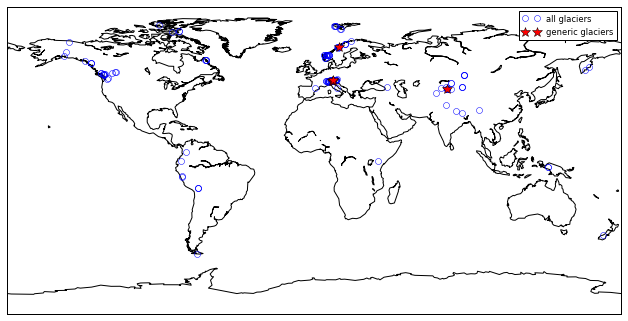

In [94]:
# Plot the 5 most generic glaciers on map
igeneric = generics.index
plt.figure(figsize=(11, 8))
m.drawcoastlines()
m.plot(data['lon'], data['lat'], 'bo', label='all glaciers', fillstyle='none')
m.plot(data['lon'].loc[igeneric], data['lat'].loc[igeneric], 'r*', label='generic glaciers', markersize=10)
plt.legend()

In [95]:
data.loc[igeneric]

,g,lat,lon,max_elevation,median_elevation,precipitation,winter_precipitation,continentality,cloud_cover,summer_temperature
316,5.728993,66.71,14.44,1300.0,1050.000000,1750.955,175.358333,21.730,72.067083,9.071667
507,6.880925,46.83,10.79,3491.0,3183.333333,1550.760,93.790000,18.725,62.957083,11.683333
510,5.220000,46.78,11.01,3420.0,2910.000000,1550.760,93.790000,18.725,62.957083,11.683333
675,5.137730,46.96,11.23,2995.4,2780.200000,1550.760,93.790000,18.725,62.957083,11.683333
805,3.586108,41.83,78.17,4800.0,4252.000000,311.725,10.395000,29.255,51.806667,11.983333


### What happens if we use the transpose of the data matrix in the PCA?

In [102]:
# Remove the 'rmse' column that we added earlier
if 'rmse' in data_st.columns:
    data_st = data_st.drop('rmse', axis=1)

data_in = data_st.T
data_in

,2000,1305,535,491,480,507,547,510,583,483,...,1456,291,2307,305,76,156,90,3334,1388,205
g,0.729295,-1.252792,1.075809,-0.521870,-0.442849,0.341358,0.347983,-0.186006,-0.028100,-0.107773,...,-0.458226,-0.373960,-0.135945,-0.732913,4.082598,-0.461272,0.312033,1.799200,-1.140466,1.204881
lat,-4.510634,-0.009790,0.009659,-0.020399,-0.018189,-0.019073,-0.009348,-0.021283,-0.006696,-0.018189,...,1.394126,1.397663,1.388380,1.317212,0.030877,0.620558,0.708081,0.491482,0.973747,0.048117
lon,-0.917411,0.221562,0.230660,0.190768,0.182089,0.191048,0.221282,0.194127,0.212044,0.181389,...,0.221702,0.208964,0.207984,0.255016,-1.658436,-2.015930,-1.995214,-1.840402,-1.973098,-1.654376
max_elevation,-1.305564,0.000761,-0.028636,0.563344,0.140396,0.398354,0.096301,0.346175,0.467437,0.155095,...,-1.395592,-1.689561,-1.748355,-1.571973,-0.884086,0.037507,-0.359351,-1.138369,-0.182970,-0.590852
median_elevation,-1.127617,0.077903,0.002036,0.366006,0.180323,0.474938,0.218256,0.267569,0.153769,0.267569,...,-1.560815,-1.689788,-1.697374,-1.636681,-0.718696,-1.333215,-0.544203,-1.105615,-0.400056,-0.483510
precipitation,-1.008986,0.634920,0.469699,0.510896,0.761253,0.510896,0.634920,0.510896,0.669535,0.761253,...,-0.501419,-0.514405,-0.641892,-0.712866,0.429471,-0.825336,-1.413473,-0.476557,-1.600750,-0.157370
winter_precipitation,-0.826765,0.080425,-0.047412,0.116703,0.383669,0.116703,0.080425,0.116703,0.135622,0.383669,...,-0.141377,-0.160869,-0.313530,-0.287175,1.825171,-0.742943,-1.384616,-0.229353,-1.378192,0.765539
continentality,-1.567918,-0.270948,-0.119936,-0.283999,-0.392131,-0.283999,-0.270948,-0.283999,-0.341794,-0.392131,...,-0.015532,-0.032311,-0.116207,0.060285,-0.366652,1.088167,1.816508,0.125538,2.055146,-0.154737
cloud_cover,-0.073330,-0.285946,-0.311797,-0.129189,0.038174,-0.129189,-0.285946,-0.129189,-0.127430,0.038174,...,0.542450,0.382869,0.422151,0.630290,0.748084,1.098482,0.730708,1.343131,0.323705,0.660831
summer_temperature,-0.610002,0.303656,1.032093,0.308183,0.054305,0.308183,0.303656,0.308183,-0.066410,0.054305,...,-2.234368,-2.185327,-1.903912,-1.604766,0.404000,-0.323683,0.256879,-0.177693,-0.405542,0.075430


In [103]:
kmax = 3
pca_t = utils.princomp(data_in, kmax=kmax)
eigval_t, eigvec_t, PCs_t = pca_t['eigval'], pca_t['eigvec'], pca_t['scores']

array([ 0.36733466,  0.32167653,  0.11470728,  0.07261724,  0.05809923])

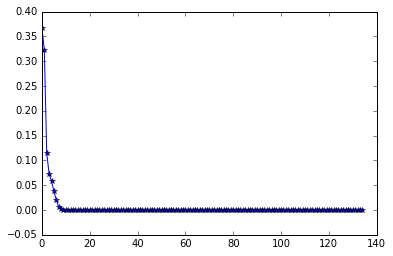

In [105]:
plt.plot(pca_t['varfrac_all'], '*-')

In [108]:
display(pca['varfrac'])
display(pca_t['varfrac'])

array([ 0.37240118,  0.29924396,  0.11863338])

array([ 0.36733466,  0.32167653,  0.11470728])

In [109]:
def plot_eigvec_t(eigvec, imode, varfrac=None, x=None):
    vec = eigvec[imode]
    if x is None:
        x = range(1, len(vec) + 1)
    plt.plot(x, vec)
    plt.xlabel('index of glaciers')
    title = 'e%d' % (imode + 1)
    if varfrac is not None:
        title = title + ' var=%.2f' % varfrac[imode]
    plt.title(title)

    
def plot_pc_t(PCs, imode, x=None):
    pc = PCs[:, imode]
    if x is None:
        x = range(1, len(pc) + 1)
    plt.plot(x, pc)
    plt.xlabel('variables')
    plt.title('PC%d' % (imode + 1))
    

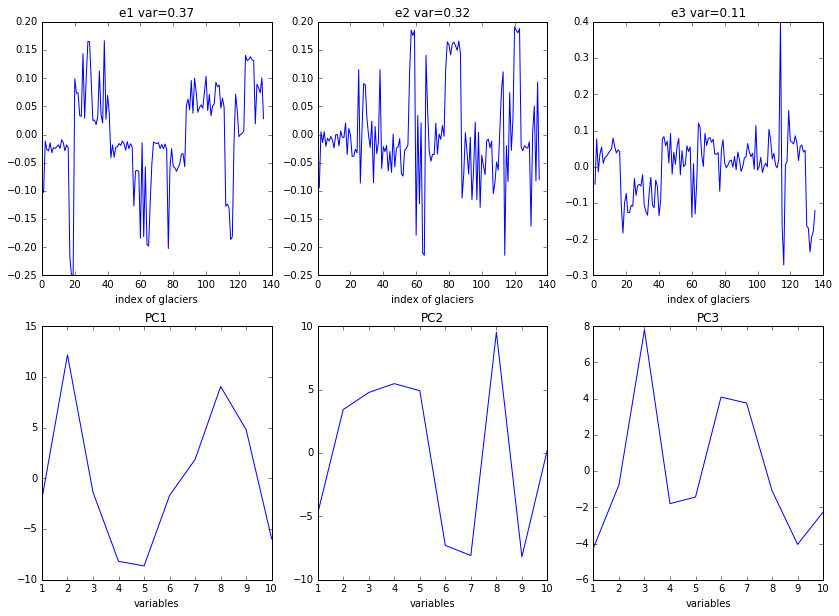

In [110]:
plot_modes(eigvec_t, PCs_t, kmax=3, eigvec_func=plot_eigvec_t, pc_func=plot_pc_t,
           eigvec_kw={'varfrac' : pca_t['varfrac']}, eigvec_as_rows=True,
           subplots_kw={'figsize' : (14, 10)})